# Convolutional Neural Networks

Realizaremos un ejercicio descrito en el guion de la prueba final para hacer reconocimiento de imágenes.

# Importar Librerías

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy import ndimage
import cv2
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import keras
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential,Input,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization,LeakyReLU


# Cargar set de Imágenes

In [3]:
dirname = os.path.join(os.getcwd(), 'meat_images')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
    if(cant > 0):
        print(root, cant)
        directories.append(root)
        dircount.append(cant)
        cant=0

print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Users\msoria\deportesCarnes\prueba\meat_images\
C:\Users\msoria\deportesCarnes\prueba\meat_images\CLASS_02 62
C:\Users\msoria\deportesCarnes\prueba\meat_images\CLASS_03 213
C:\Users\msoria\deportesCarnes\prueba\meat_images\CLASS_04 105
C:\Users\msoria\deportesCarnes\prueba\meat_images\CLASS_05 949
C:\Users\msoria\deportesCarnes\prueba\meat_images\CLASS_06 37
C:\Users\msoria\deportesCarnes\prueba\meat_images\CLASS_07 204
C:\Users\msoria\deportesCarnes\prueba\meat_images\CLASS_08 63
Directorios leidos: 7
Imagenes en cada directorio [62, 213, 105, 949, 37, 204, 63]
suma Total de imagenes en subdirs: 1633


# Creamos las etiquetas

In [4]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  1633


In [5]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 CLASS_02
1 CLASS_03
2 CLASS_04
3 CLASS_05
4 CLASS_06
5 CLASS_07
6 CLASS_08


In [6]:
y = np.array(labels)


datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range =0.3, 
    zoom_range = 0.3,
    horizontal_flip = True
)

images_scaled = [datagen.random_transform(image) for image in images]
X = np.array(images_scaled)


# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)



Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


# Creamos Sets de Entrenamiento y Test

In [7]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (1306, 216, 384, 3) (1306,)
Testing data shape :  (327, 216, 384, 3) (327,)


Text(0.5, 1.0, 'Ground Truth : 1')

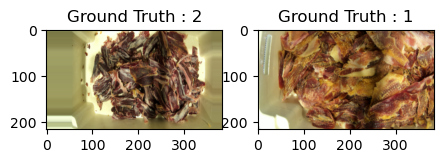

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

## Hacemos el One-hot Encoding para la red

In [9]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [10]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [11]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(1044, 216, 384, 3) (262, 216, 384, 3) (1044, 7) (262, 7)


# Creamos el modelo de CNN

In [12]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 0.0005 # Valor inicial de learning rate.
epochs = 10 #  Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 32 #  cantidad de imágenes que se toman a la vez en memoria

In [13]:
meat_model = Sequential()
meat_model.add(Conv2D(32, (3, 3),activation='relu',padding='same',input_shape=(216, 384,3)))
meat_model.add(MaxPooling2D((2, 2)))
meat_model.add(Conv2D(64, (2, 2),activation='relu',padding='same'))
meat_model.add(MaxPooling2D((2, 2)))

meat_model.add(Flatten())
meat_model.add(Dense(256, activation='relu'))

meat_model.add(Dropout(0.5))
meat_model.add(Dense(nClasses, activation='softmax'))



In [14]:
meat_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 216, 384, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 108, 192, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 192, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 96, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 331776)            0         
                                                                 
 dense (Dense)               (None, 256)               8

In [15]:

meat_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [16]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# como ejemplo, en mi Macbook pro tarda 4 minutos
meat_train = meat_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/10
33/33 [==============================] - 175s 5s/step - loss: 3.4269 - accuracy: 0.4588 - val_loss: 1.0678 - val_accuracy: 0.6145
Epoch 2/10
33/33 [==============================] - 136s 4s/step - loss: 1.0615 - accuracy: 0.6437 - val_loss: 0.7917 - val_accuracy: 0.6947
Epoch 3/10
33/33 [==============================] - 125s 4s/step - loss: 0.7789 - accuracy: 0.7347 - val_loss: 0.6384 - val_accuracy: 0.7824
Epoch 4/10
33/33 [==============================] - 122s 4s/step - loss: 0.6053 - accuracy: 0.7874 - val_loss: 0.6095 - val_accuracy: 0.7443
Epoch 5/10
33/33 [==============================] - 119s 4s/step - loss: 0.5229 - accuracy: 0.8161 - val_loss: 0.6005 - val_accuracy: 0.8092
Epoch 6/10
33/33 [==============================] - 123s 4s/step - loss: 0.4180 - accuracy: 0.8621 - val_loss: 0.5161 - val_accuracy: 0.8015
Epoch 7/10
33/33 [==============================] - 129s 4s/step - loss: 0.2770 - accuracy: 0.9157 - val_loss: 0.4802 - val_accuracy: 0.8168
Epoch 8/10
33

In [17]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
meat_model.save("meat_mnist.h5py")

INFO:tensorflow:Assets written to: meat_mnist.h5py\assets


INFO:tensorflow:Assets written to: meat_mnist.h5py\assets


# Evaluamos la red

In [18]:
test_eval = meat_model.evaluate(test_X, test_Y_one_hot, verbose=1)

11/11 [==============================] - 5s 437ms/step - loss: 0.5330 - accuracy: 0.8349


In [19]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.5330280661582947
Test accuracy: 0.8348624110221863


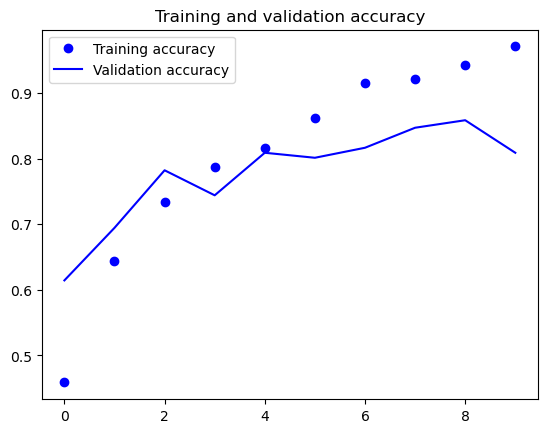

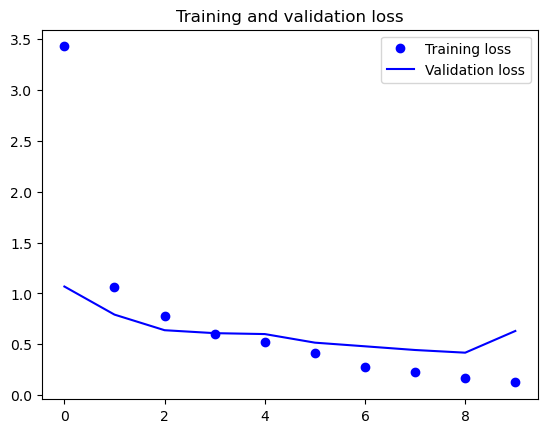

In [20]:
accuracy = meat_train.history['accuracy']
val_accuracy = meat_train.history['val_accuracy']
loss = meat_train.history['loss']
val_loss = meat_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
predicted_classes2 = meat_model.predict(test_X)

11/11 [==============================] - 5s 475ms/step


In [22]:
predicted_classes=[]
for predicted_meat in predicted_classes2:
    predicted_classes.append(predicted_meat.tolist().index(max(predicted_meat)))
predicted_classes=np.array(predicted_classes)

In [23]:
predicted_classes.shape, test_Y.shape

((327,), (327,))

# Aprendamos de los errores: Qué mejorar

Found 273 correct labels


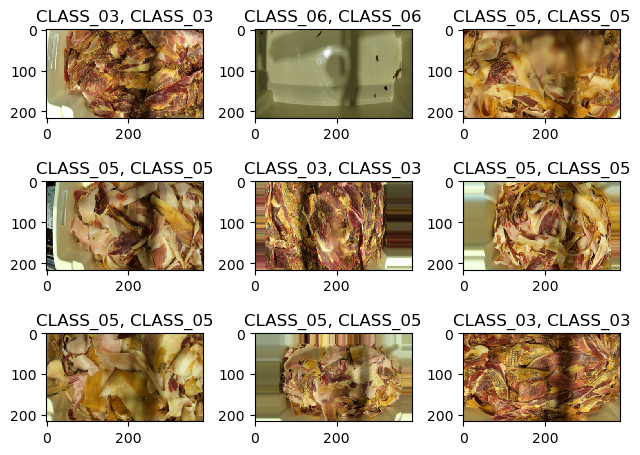

In [24]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(216, 384,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 54 incorrect labels


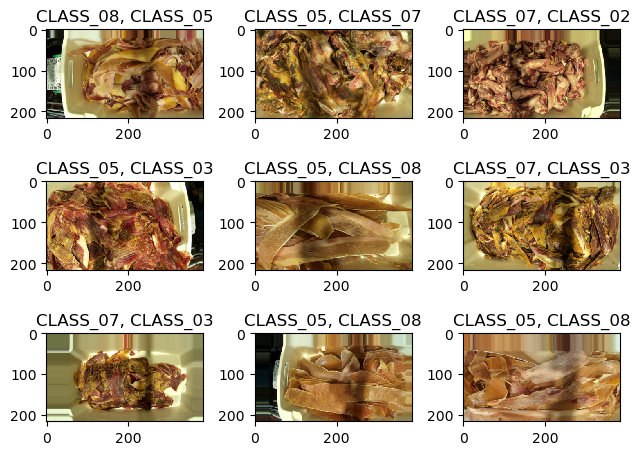

In [25]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(216, 384,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [26]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         9
     Class 1       0.88      0.59      0.71        37
     Class 2       0.69      0.95      0.80        21
     Class 3       0.89      0.96      0.92       192
     Class 4       1.00      0.89      0.94         9
     Class 5       0.68      0.92      0.78        39
     Class 6       0.67      0.10      0.17        20

    accuracy                           0.83       327
   macro avg       0.69      0.63      0.62       327
weighted avg       0.81      0.83      0.80       327



C:\Users\msoria\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msoria\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msoria\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Prediccion de una nueva imagen

In [27]:
from skimage.transform import resize
images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
#filenames = ['test/CLASS_03_0113.jpg']
dirpath = os.path.join(os.getcwd(), 'test')
for root, dirnames, filenames in os.walk(dirpath):
    for filename in filenames:
        filepath=os.path.join(root,filename)
        image = plt.imread(filepath,0)
        image_resized = resize(image, (216, 384),anti_aliasing=True,clip=False,preserve_range=True)
        images.append(image_resized)
        
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range =0.3, 
    zoom_range = 0.3,
    horizontal_flip = True
    
      # rotation_range=40,
    #width_shift_range=0.2,
   # height_shift_range=0.2,
   # shear_range=0.2,
   # zoom_range=0.2,
   # horizontal_flip=True,
   # fill_mode='nearest'
)
images_scaled = [datagen.random_transform(image) for image in images]
X = np.array(images_scaled)

predicted_classes = meat_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    if i < len(images_scaled):
        print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])


11/11 [==============================] - 5s 438ms/step
00-CAPTURE_20220531_001105_440_6.png CLASS_03
05-CAPTURE_20220421_053444_089_3.png CLASS_06
07-CAPTURE_20220422_070756_979_8.png CLASS_05
09-CAPTURE_20220420_090647_800_7.png CLASS_05
